# Predict Lodging Price
New York Accommodation Ltd (NYA) is an online booking service for New York lodging. NYA wants to estimate a fair price of lodgings dependent on some features. Using machine learning, predict lodging prices and identify how different features influence the prediction.

#### Files
```
train.csv
test.csv
sample_output.csv
 ```

### Problem

Perform an analysis of the given data to determine how different features are related to price. Build a machine learning model that can predict the price. For each record in the test set (test.csv), predict the value of the price variable . Submit a CSV file with a header row plus each of the test entries, each on its own line. The file (submissions.csv) should have exactly 2 columns:

```
id
price
 ```

### Deliverables

Well commented Jupyter notebook
“submissions.csv”
 
Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences.

#### Other Criteria Considered
* Code quality and clarity such as well formated and commented functions.
* Algorithm sophistication.
 

### Evaluation Metric
The metric used for evaluating the performance of Mean Absolute Percent Error.

MAPE = MAPE is the mean of the absolute percentage errors of forecasts.


In [134]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [135]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats ## For ANOVA
from sklearn.linear_model import LinearRegression ## For LinearRegression to check Relationships between Features and Label
from sklearn.metrics import mean_squared_error ## To evaluate the Linear Regression
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA ## We use PCA to see if we need to reduce dimensions
from sklearn.preprocessing import StandardScaler ## To normalize numerical features
from sklearn.preprocessing import LabelEncoder ## LabelEncode categorical features
from sklearn.svm import SVR ## Support Vector Regression model with non-linear kernel
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV ## for tuning hyperparameters

pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", None)

In [136]:
## Define the look of the Seaborn plots
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale = 1)

## Data Description

Column | Description
:---|:---
`District` | The name of the district 
`Neighborhood` | The name of the neighborhood area
`PropertyType` | The type of the property
`CancellationPolicy` | The easiness of cancelling the reservation
`Accomodates` | The number of guests the lodging can handle 
`RoomType` | The type of the lodging.
`Bathrooms` | The number of bathrooms
`Bedrooms` | The number of bedrooms
`CleaningFee` | The fee charged to clean the room after ending the accommodation
`Latitude` | Latitude of the property
`Longitude` | Longitude of the property
`ReviewRating`|  The average score of reviews
`Price` | The lodging price per night (Target Variable)

## Data Wrangling & Visualization

In [137]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [138]:
data.head()

,ID,District,Neighborhood,PropertyType,CancellationPolicy,Accommodates,RoomType,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating,Price
0,5300082,Manhattan,East Village,Apartment,strict,2,Entire home/apt,1.000000,0.000000,75.000000,40.729555,-73.981665,86.000000,160.000000
1,17634206,Manhattan,Hell's Kitchen,Apartment,flexible,2,Entire home/apt,1.000000,1.000000,66.646525,40.766988,-73.984802,100.000000,130.000000
2,4025329,Manhattan,Harlem,Apartment,strict,4,Entire home/apt,1.000000,0.000000,69.000000,40.815859,-73.941165,91.000000,129.000000
3,10096773,Manhattan,Chelsea,Apartment,flexible,2,Entire home/apt,1.000000,1.000000,60.000000,40.745773,-74.000744,100.000000,145.000000
4,11616592,Manhattan,West Village,Apartment,strict,9,Entire home/apt,2.500000,3.000000,160.000000,40.737583,-74.005531,94.000000,399.000000


In [139]:
#Explore columns
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price'],
      dtype='object')

In [140]:
#Description_1
data.describe()

,ID,Accommodates,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating,Price
count,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000
mean,9106358.619376,2.825280,1.079888,1.071751,65.885569,40.764355,-73.973329,92.771483,161.343014
std,5554031.899199,1.597897,0.297259,0.624387,36.712840,0.039444,0.023235,8.663176,110.364870
min,2515.000000,1.000000,0.000000,0.000000,0.000000,40.586936,-74.018104,20.000000,14.000000
25%,4211459.000000,2.000000,1.000000,1.000000,45.000000,40.729555,-73.991395,90.000000,90.000000
50%,9276587.000000,2.000000,1.000000,1.000000,66.646525,40.760719,-73.980025,95.000000,130.000000
75%,14122281.000000,4.000000,1.000000,1.000000,75.000000,40.795867,-73.952133,100.000000,200.000000
max,18491399.000000,16.000000,5.000000,5.000000,300.000000,40.876831,-73.798061,100.000000,999.000000


In [141]:
#Description_2
data.describe(exclude=np.number)

,District,Neighborhood,PropertyType,CancellationPolicy,RoomType
count,4201,4201,4201,4201,4201
unique,4,63,16,3,3
top,Manhattan,Harlem,Apartment,strict,Entire home/apt
freq,4116,549,3966,2277,2384


## Exploratory Data Analysis

This EDA aims at understanding the underlying data and relationships between the features present in the dataset. Some questions that the EDA is going to try to answer are:
1. Are there data imbalances? How are categorical features behaving? 
2. What affects the price of a rental? Can we get a sense of what relationships there are currently? Is there a correlation with any of the features?
3. We need to get ground truth so we can compare the model's feature importance and the model's output.
4. Do we need to do feature engineering?

The EDA consists of the following tests:
1. Correlation between numeric variables and Price
2. ANOVA for categorical variables
3. Visual Analysis of features 
4. Label Encoding of categorical variables
5. Principal Component Analysis to see whether we can reduce dimensionality
6. Elbow Method to determine how many principal components to use
7. Linear Regression checks to determine whether there is a linear relationships between the features and the labels, so we can choose the correct model
8. Feature engineering

But first, here is a summary of the insights found during the EDA
### Executive Summary:
1. An XGBoost regression model predicts rental prices with less than 3% error

### Insights

1. Price is correlated with Accomodates, Bathrooms, Bedrooms, and Cleaning Fee
2. Rentals are more expensive in Manhattan and the price varies more than in other neighborhoods
3. The most expensive rentals have 2-3 bathrooms
4. The most expensive rentals 2-4 bedrooms
5. One district - Bronx, has only 2 rentals in the training dataset
6. 19 neighborhoods have only 1 rental in the training dataset
7. Most rentals are apartments (~94%)
8. Vacation homes are most expensive, and there is a group of similarly-priced property types
9. Entire homes are more expensive than private and shared rooms
10. Most rentals accommodate 2 people
11. Most rentals have 1 bathroom
12. Most rentals have 1 bedroom
13. Manhattan has more varied property types
14. Bronx only has Strict policy
15. It is unlikely that we can use dimension reduction
16. There are no linear relationships between the features and Price, we can use SVR or XGBoost
17. We need to engineer features to account for the fact that some neighborhoods will only have one or two rentals, and to find the relationships between rental sizes and price, or price per person, etc.
18. We need aggregated features when we don't know the prices yet (for the test data)

### 1. Correlation between numeric variables and Price

The correlation matrix will give us an idea of how the numerical features are related to the label - Price

In [142]:
corr = data.corr()

<AxesSubplot:>

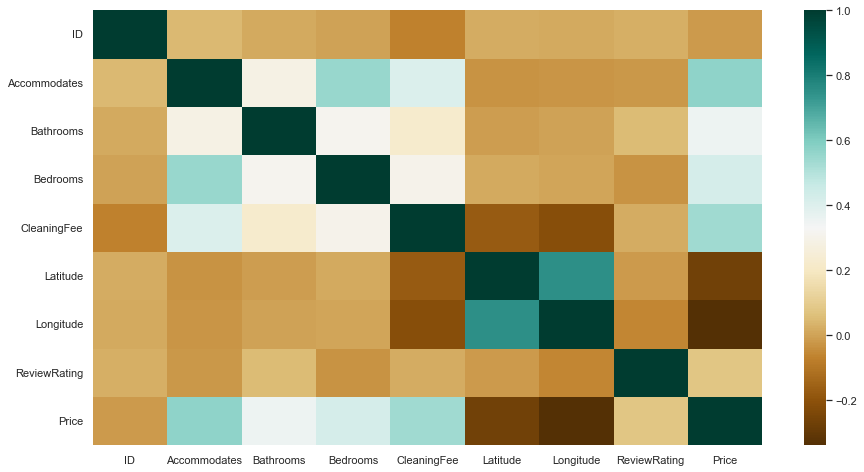

In [143]:
## Plot the correlation map
sns.heatmap(corr,cmap='BrBG')

#### 1.1. Visually check whether there is linear relationships between Price and: Accommodates, bathrooms, Bedrooms, CleaningFee
This will tell us whether the correlation map makes sense and will reveal how the Price behaves in different Neighborhoods

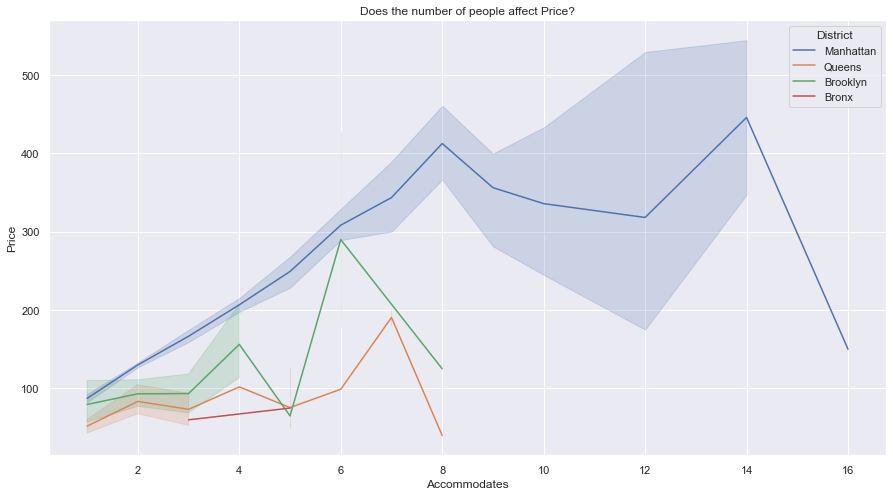

In [144]:
sns.lineplot(x=data.Accommodates, y=data.Price, hue=data.District)
plt.xlabel("Accommodates")
plt.ylabel("Price")
plt.title("Does the number of people affect Price?")

# Show the plot
plt.show()

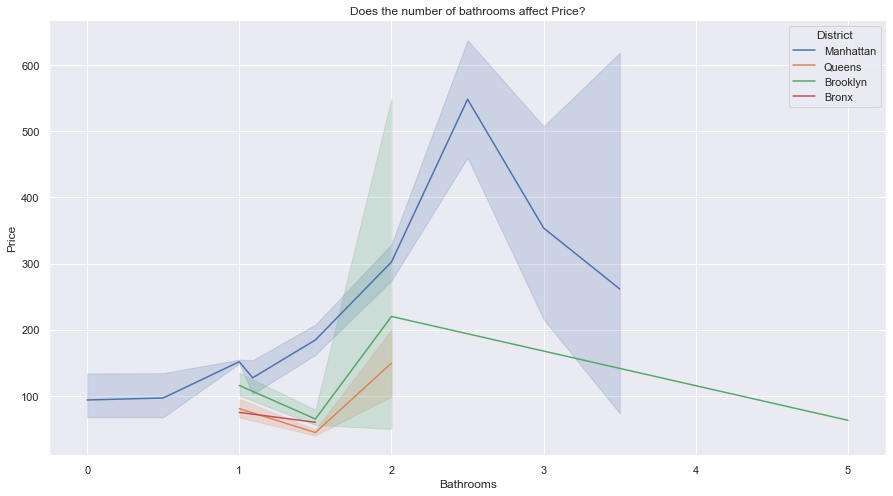

In [145]:
sns.lineplot(x=data.Bathrooms, y=data.Price, hue=data.District)
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.title("Does the number of bathrooms affect Price?")

# Show the plot
plt.show()

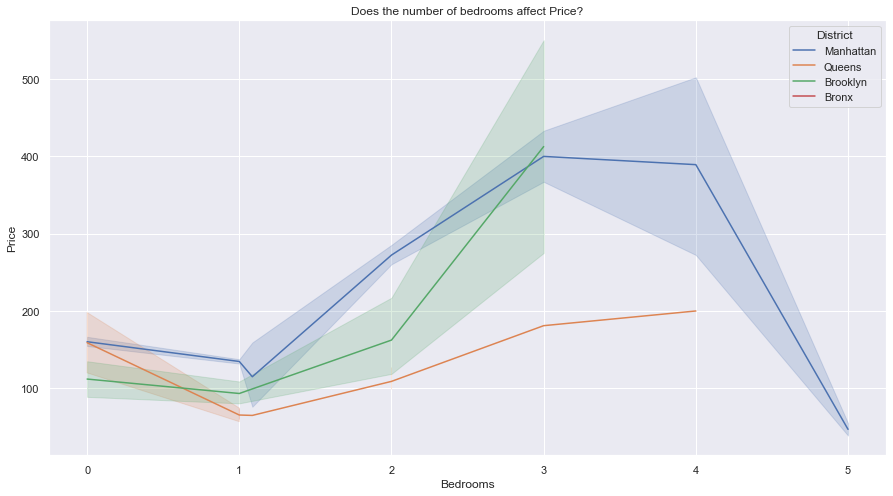

In [146]:
sns.lineplot(x=data.Bedrooms, y=data.Price, hue=data.District)
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.title("Does the number of bedrooms affect Price?")

# Show the plot
plt.show()

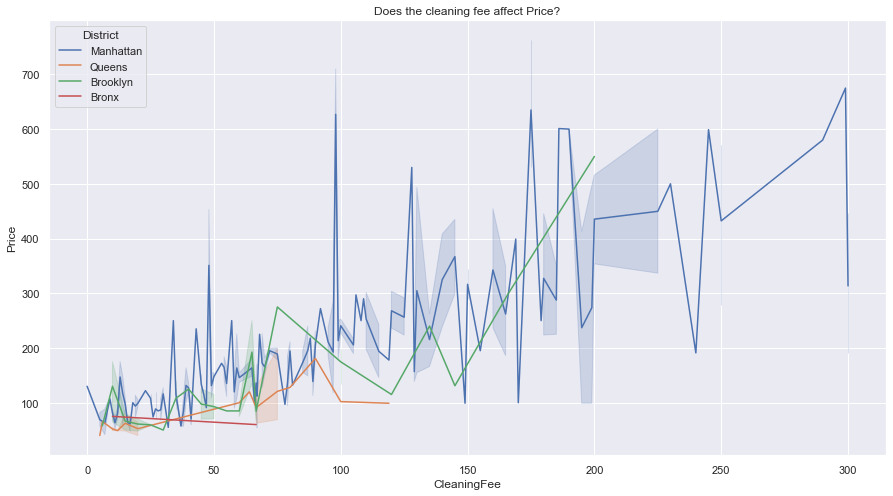

In [147]:
sns.lineplot(x=data.CleaningFee, y=data.Price, hue=data.District)
plt.xlabel("CleaningFee")
plt.ylabel("Price")
plt.title("Does the cleaning fee affect Price?")

# Show the plot
plt.show()

CleaningFee seems to be related to Price, which makes sense. We need to create a column that is a ration between CleaningFee and Price

### 2. ANOVA
We are using ANOVA on categorical values to measure the means of Price across the different categorical variables, and to see whether there are statistically significant differences in means among groups

In [148]:
# We need to define the categorical columns we are going to do ANOVA on
categorical_columns = ['District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 'RoomType']

# Define the significance level
alpha = 0.05

# Store the ANOVA results in a dataframe
anova_results = pd.DataFrame(columns=['Categorical_Variable', 'F-Statistic', 'P-Value'])

# Loop through each categorical variable and perform ANOVA
for col in categorical_columns:
    group = data.groupby(col)['Price']
    f_statistic, p_value = stats.f_oneway(*[group for _, group in group])
    
    # Append results to the dataframe
    anova_results = anova_results.append({'Categorical_Variable': col,
                                          'F-Statistic': f_statistic,
                                          'P-Value': p_value}, ignore_index=True)

# The p_values can sometimes be displayed in scientific format. This changes that to floats
pd.options.display.float_format = '{:.6f}'.format

# Print the ANOVA results
print(anova_results)

# Are there a significant differences?
significant_variables = anova_results[anova_results['P-Value'] < alpha]['Categorical_Variable'].tolist()
print("Categorical variables with significant differences in means:", significant_variables)

  Categorical_Variable  F-Statistic  P-Value
0             District     8.862968 0.000007
1         Neighborhood    12.365842 0.000000
2         PropertyType    10.080759 0.000000
3   CancellationPolicy    52.136753 0.000000
4             RoomType   791.851865 0.000000
Categorical variables with significant differences in means: ['District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 'RoomType']


##### P-values of 0 can mean a few things: the sample could be too small, the data could be skewed.

### 3. Visual Analysis of Features
Next, we are going to plot the features so we can understand their relationship with Price, and to spot some outliers or potential issues for the model later on.
We are going to first check the value counts of a column - how many rentals there are in a specific District for example, and then we are going to plot each District to see how Price behaves, and similar for each feature.

#### Categorical Features

In [149]:
## How many districts there are and how many rentals in each
data.District.value_counts()

Manhattan    4116
Brooklyn       50
Queens         33
Bronx           2
Name: District, dtype: int64

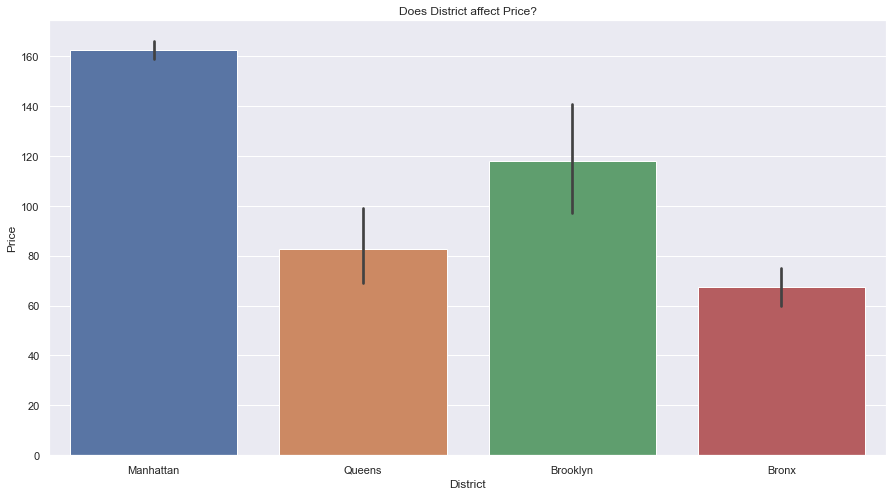

In [150]:
sns.barplot(x=data.District, y=data.Price)

plt.xlabel("District")
plt.ylabel("Price")
plt.title("Does District affect Price?")

# Show the plot
plt.show()

In [151]:
data.Neighborhood.value_counts()

Harlem                       549
East Village                 411
Hell's Kitchen               365
Upper West Side              365
Upper East Side              343
East Harlem                  246
Chelsea                      215
Lower East Side              206
Midtown                      184
Washington Heights           176
West Village                 173
Kips Bay                      90
Chinatown                     85
SoHo                          84
Greenwich Village             77
Financial District            70
Gramercy                      68
Nolita                        68
Morningside Heights           67
Murray Hill                   64
Inwood                        38
Theater District              33
Tribeca                       29
Little Italy                  25
Flatiron District             19
NoHo                          16
Williamsburg                  16
Roosevelt Island              13
Battery Park City             12
Two Bridges                   10
Long Islan

##### There are 19 Neighborhoods that have only 1 rental. 

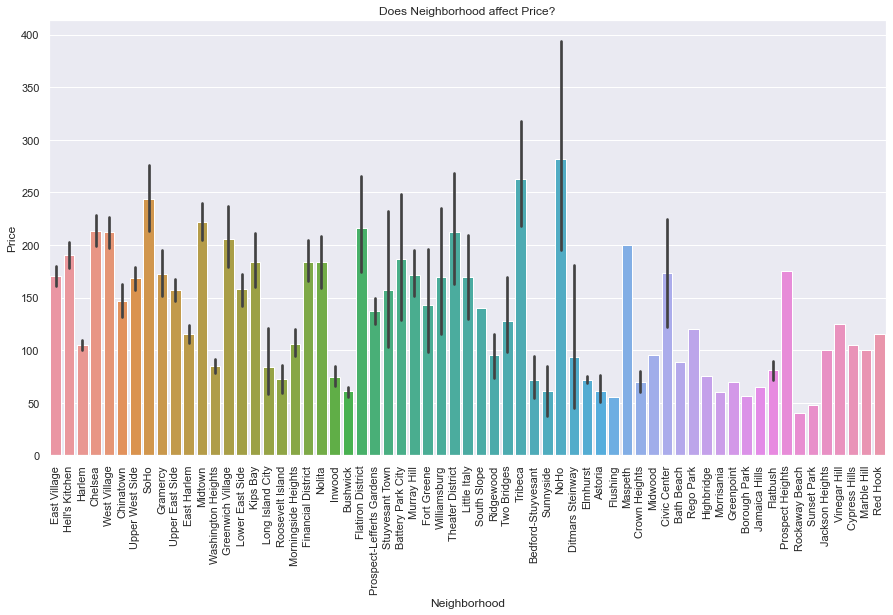

In [152]:
sns.barplot(x=data.Neighborhood, y=data.Price)

plt.xlabel("Neighborhood")
plt.ylabel("Price")
plt.title("Does Neighborhood affect Price?")
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [153]:
data.PropertyType.value_counts()

Apartment          3966
House                59
Loft                 48
Condominium          42
Townhouse            37
Other                25
Bed & Breakfast       9
Timeshare             7
Hut                   1
Lighthouse            1
Boutique hotel        1
Hostel                1
Guesthouse            1
Vacation home         1
Dorm                  1
Villa                 1
Name: PropertyType, dtype: int64

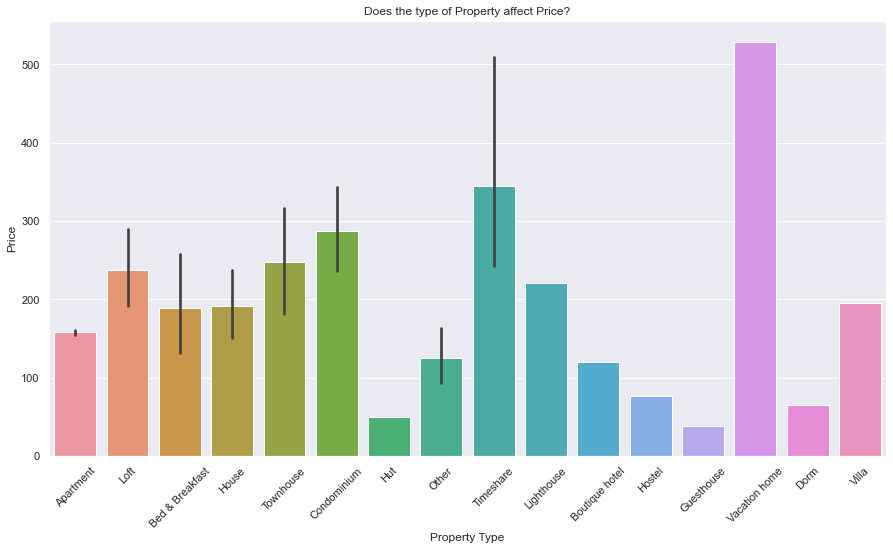

In [154]:
sns.barplot(x=data.PropertyType, y=data.Price)

plt.xlabel("Property Type")
plt.ylabel("Price")
plt.title("Does the type of Property affect Price?")
plt.xticks(rotation=45)

# Show the plot
plt.show()

##### Most rentals are Apartments

In [155]:
data.CancellationPolicy.value_counts()

strict      2277
moderate     993
flexible     931
Name: CancellationPolicy, dtype: int64

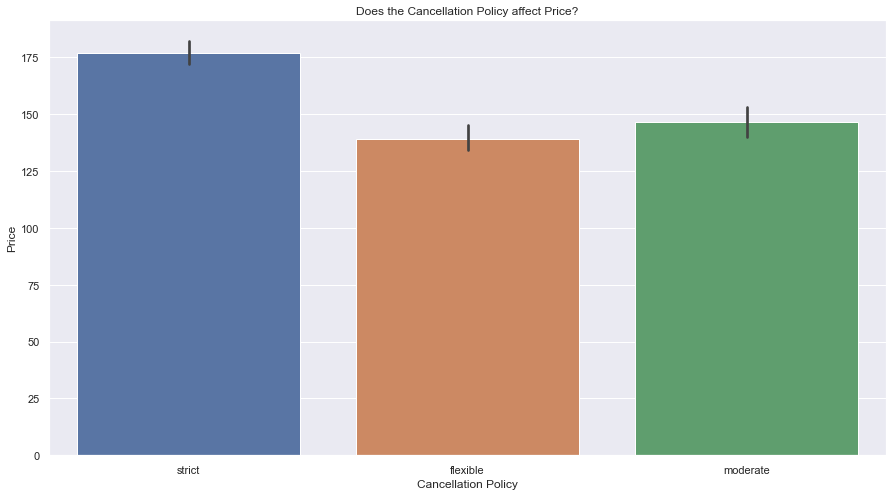

In [156]:
sns.barplot(x=data.CancellationPolicy, y=data.Price)

# Add labels and a title
plt.xlabel("Cancellation Policy")
plt.ylabel("Price")
plt.title("Does the Cancellation Policy affect Price?")

# Show the plot
plt.show()

In [157]:
data.RoomType.value_counts()

Entire home/apt    2384
Private room       1694
Shared room         123
Name: RoomType, dtype: int64

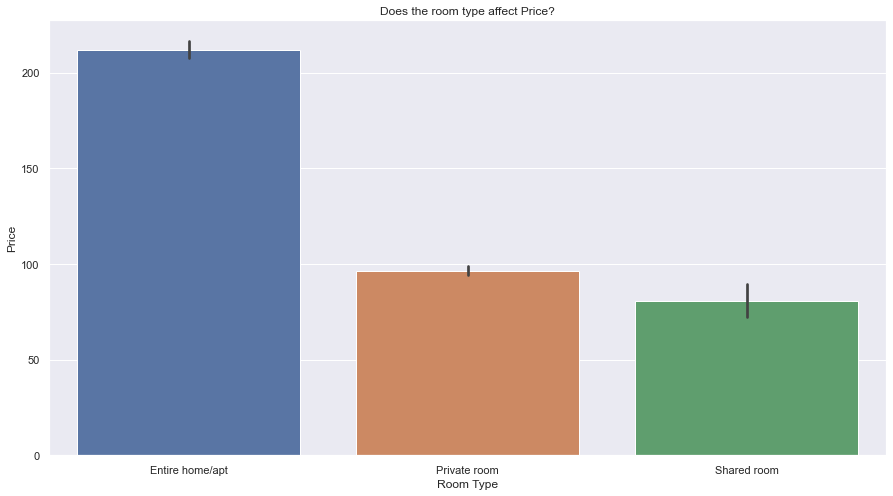

In [158]:
sns.barplot(x=data.RoomType, y=data.Price)

# Add labels and a title
plt.xlabel("Room Type")
plt.ylabel("Price")
plt.title("Does the room type affect Price?")

# Show the plot
plt.show()

### Numerical Features

In [159]:
data.Accommodates.value_counts()

2     2034
4      658
3      520
1      487
6      217
5      161
8       59
7       41
10      14
9        4
12       3
14       2
16       1
Name: Accommodates, dtype: int64

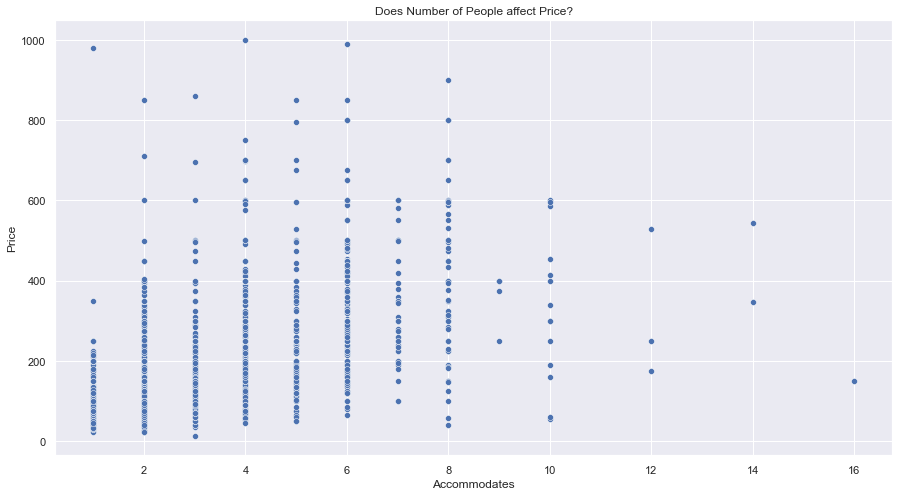

In [160]:
sns.scatterplot(x=data.Accommodates, y=data.Price)

# Add labels and a title
plt.xlabel("Accommodates")
plt.ylabel("Price")
plt.title("Does Number of People affect Price?")

# Show the plot
plt.show()

In [161]:
data.Bathrooms.value_counts()

1.000000    3751
2.000000     232
1.500000     137
1.087878      24
0.000000      18
2.500000      17
0.500000       9
3.000000       8
3.500000       4
5.000000       1
Name: Bathrooms, dtype: int64

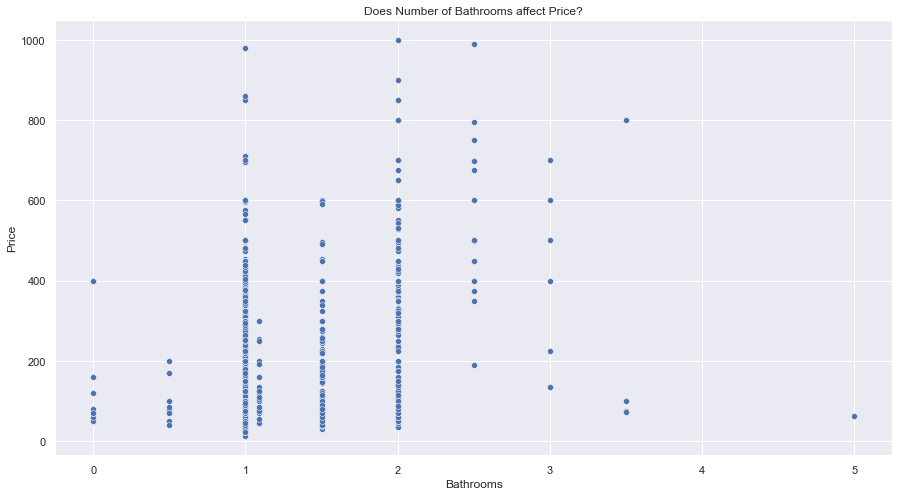

In [162]:
sns.scatterplot(x=data.Bathrooms, y=data.Price)

# Add labels and a title
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.title("Does Number of Bathrooms affect Price?")

# Show the plot
plt.show()

In [163]:
data.Bedrooms.value_counts()

1.000000    3060
2.000000     501
0.000000     497
3.000000     119
4.000000      17
1.085586       5
5.000000       2
Name: Bedrooms, dtype: int64

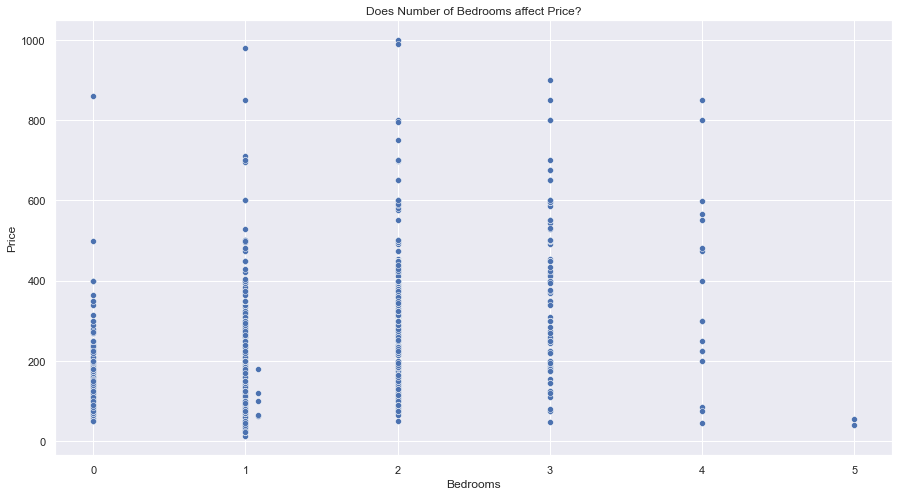

In [164]:
sns.scatterplot(x=data.Bedrooms, y=data.Price)

# Add labels and a title
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.title("Does Number of Bedrooms affect Price?")

# Show the plot
plt.show()

In [165]:
data.CleaningFee.value_counts()

66.646525     1029
50.000000      441
100.000000     310
60.000000      189
30.000000      180
20.000000      180
75.000000      179
80.000000      155
40.000000      154
25.000000      152
150.000000     120
10.000000       95
35.000000       90
15.000000       89
70.000000       88
85.000000       65
65.000000       64
125.000000      64
120.000000      62
45.000000       56
90.000000       44
95.000000       30
99.000000       26
55.000000       24
200.000000      23
5.000000        20
110.000000      15
39.000000       15
49.000000       12
79.000000       11
29.000000        8
12.000000        8
160.000000       8
89.000000        8
250.000000       7
130.000000       7
135.000000       7
140.000000       6
300.000000       6
54.000000        6
19.000000        6
7.000000         5
69.000000        5
115.000000       5
38.000000        4
58.000000        4
175.000000       4
225.000000       4
129.000000       4
180.000000       4
97.000000        4
8.000000         4
105.000000  

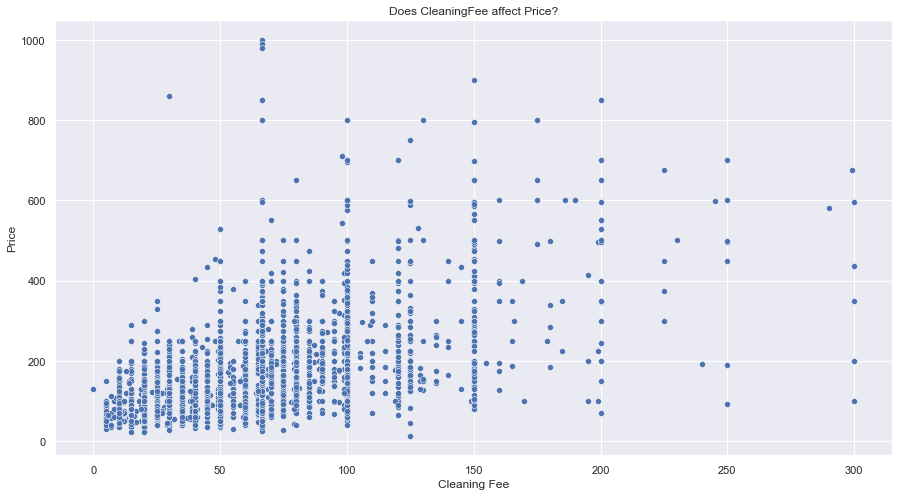

In [166]:
sns.scatterplot(x=data.CleaningFee, y=data.Price)

# Add labels and a title
plt.xlabel("Cleaning Fee")
plt.ylabel("Price")
plt.title("Does CleaningFee affect Price?")

# Show the plot
plt.show()

In [167]:
data.ReviewRating.value_counts()

100.000000    1108
93.000000      325
95.000000      303
90.000000      252
96.000000      251
80.000000      224
98.000000      210
97.000000      205
92.000000      180
94.000000      177
91.000000      137
87.000000      113
99.000000      104
88.000000      102
89.000000       97
85.000000       72
84.000000       52
83.000000       44
60.000000       44
86.000000       37
70.000000       25
82.000000       21
78.000000       15
81.000000       13
75.000000       13
73.000000       12
76.000000       11
20.000000       10
40.000000        8
77.000000        7
67.000000        7
74.000000        6
79.000000        5
72.000000        3
53.000000        2
50.000000        2
68.000000        2
65.000000        1
27.000000        1
Name: ReviewRating, dtype: int64

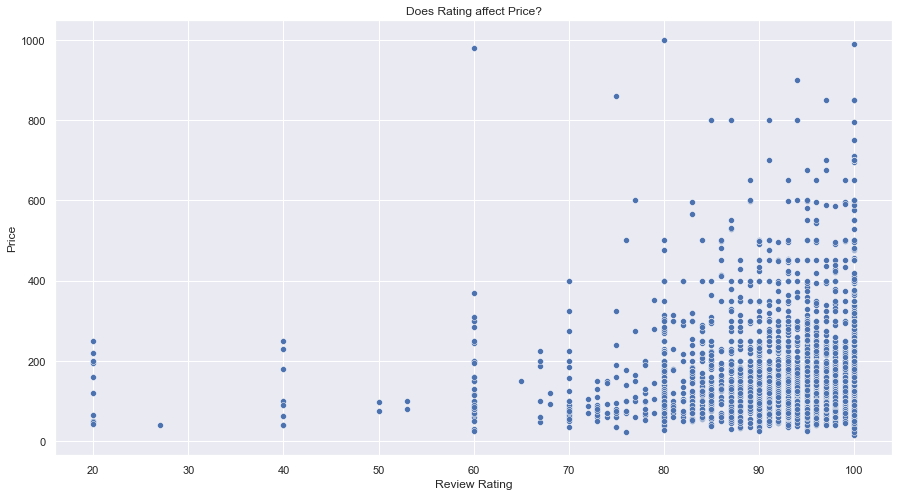

In [168]:
sns.scatterplot(x=data.ReviewRating, y=data.Price)

# Add labels and a title
plt.xlabel("Review Rating")
plt.ylabel("Price")
plt.title("Does Rating affect Price?")

# Show the plot
plt.show()

##### Let's see whether there are differences between Districts in the rest of the features

In [169]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price'],
      dtype='object')

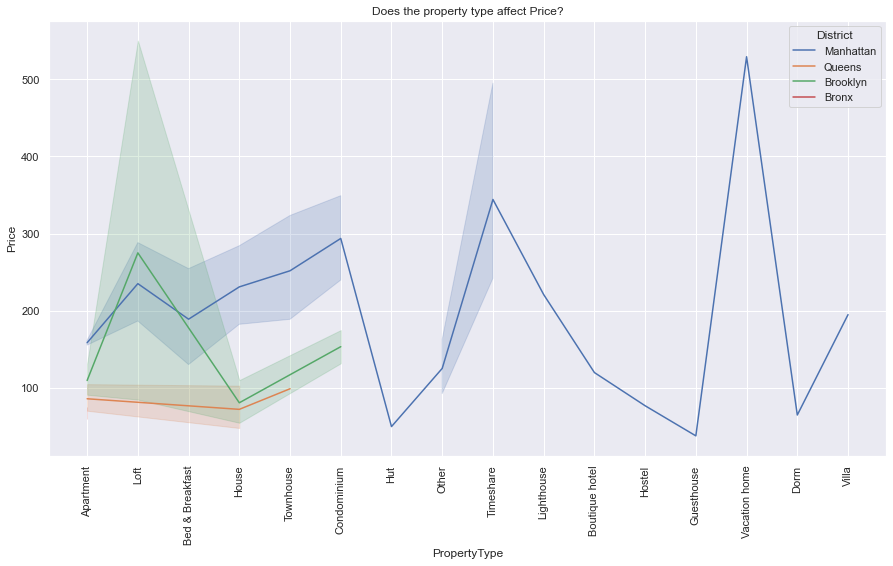

In [170]:
sns.lineplot(x=data.PropertyType, y=data.Price, hue=data.District)
plt.xlabel("PropertyType")
plt.ylabel("Price")
plt.title("Does the property type affect Price?")
plt.xticks(rotation=90)

# Show the plot
plt.show()

##### Only Manhattan has variety of Property Types

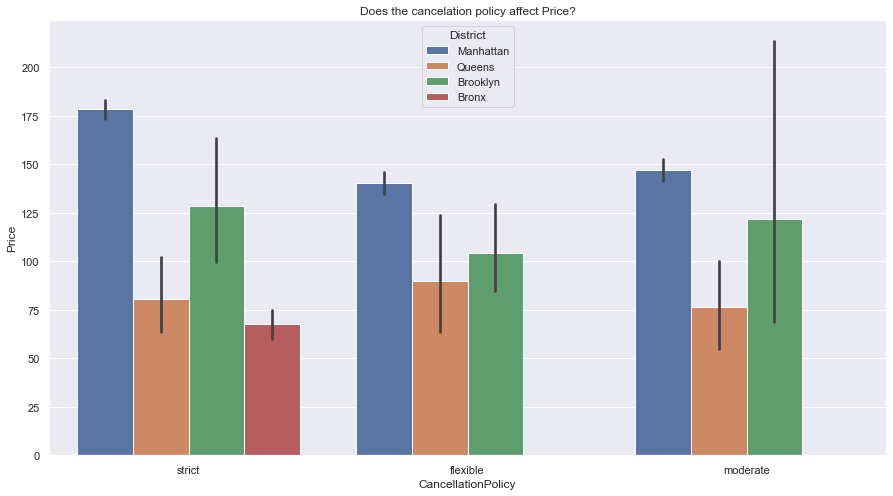

In [171]:
sns.barplot(x=data.CancellationPolicy, y=data.Price, hue=data.District)
plt.xlabel("CancellationPolicy")
plt.ylabel("Price")
plt.title("Does the cancelation policy affect Price?")

# Show the plot
plt.show()

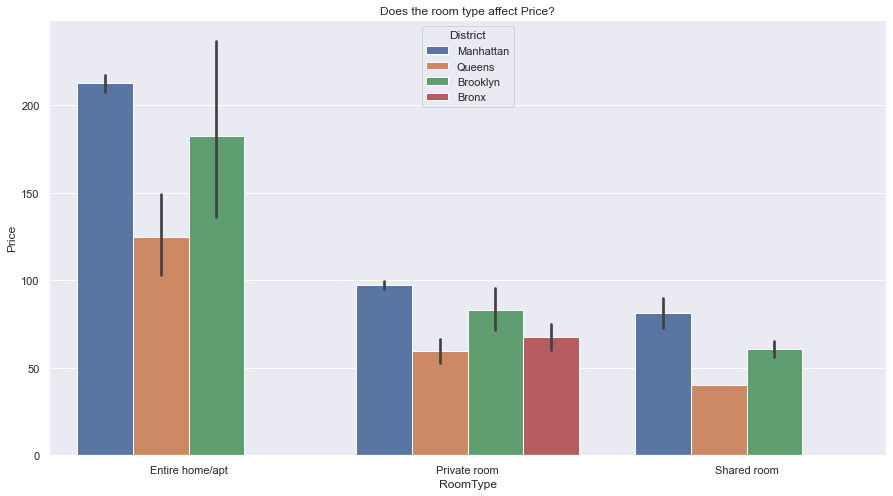

In [172]:
sns.barplot(x=data.RoomType, y=data.Price, hue=data.District)
plt.xlabel("RoomType")
plt.ylabel("Price")
plt.title("Does the room type affect Price?")

# Show the plot
plt.show()

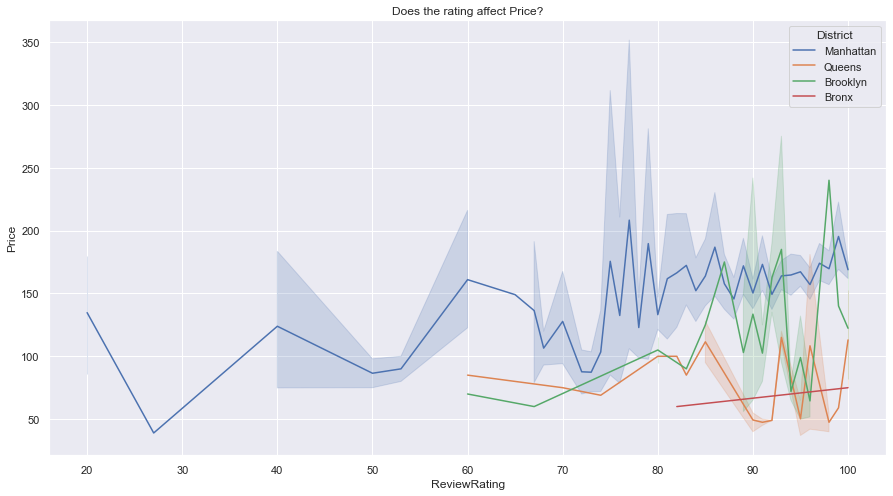

In [173]:
sns.lineplot(x=data.ReviewRating, y=data.Price, hue=data.District)
plt.xlabel("ReviewRating")
plt.ylabel("Price")
plt.title("Does the rating affect Price?")

# Show the plot
plt.show()

##### While Rating seems to be important for price, it is different for different Distritcs. We need a ratio of Rating/Price

### 4. Label Encoding of Categorical Variables
We are first going to label encode the existing columns and then repeat the excercises with engineered features. We need to do label encoding so we can represent categorical variables as numbers and do linear regression and PCA on the columns. 

In [174]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price'],
      dtype='object')

In [175]:
categorical_columns = ['District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 'RoomType']

In [176]:
# Since we are doing label encoding on all columns at once, in a loop, 
# we need a dictionary to store LabelEncoder instances for each column

label_encoders = {}

# We would like to see how the original value maps to the new label encoded value,
# so we need to create a dictionary to map the original values to the encoded values 

encoded_value_mappings = {}

# Perform label encoding for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])  # Replace the original values with encoded values
    label_encoders[col] = le
    
    # Create a mapping dictionary for the current column
    encoded_value_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

In [177]:
### show the mappings
encoded_value_mappings

{'District': {'Bronx': 0, 'Brooklyn': 1, 'Manhattan': 2, 'Queens': 3},
 'Neighborhood': {'Astoria': 0,
  'Bath Beach': 1,
  'Battery Park City': 2,
  'Bedford-Stuyvesant': 3,
  'Borough Park': 4,
  'Bushwick': 5,
  'Chelsea': 6,
  'Chinatown': 7,
  'Civic Center': 8,
  'Crown Heights': 9,
  'Cypress Hills': 10,
  'Ditmars Steinway': 11,
  'East Harlem': 12,
  'East Village': 13,
  'Elmhurst': 14,
  'Financial District': 15,
  'Flatbush': 16,
  'Flatiron District': 17,
  'Flushing': 18,
  'Fort Greene': 19,
  'Gramercy': 20,
  'Greenpoint': 21,
  'Greenwich Village': 22,
  'Harlem': 23,
  "Hell's Kitchen": 24,
  'Highbridge': 25,
  'Inwood': 26,
  'Jackson Heights': 27,
  'Jamaica Hills': 28,
  'Kips Bay': 29,
  'Little Italy': 30,
  'Long Island City': 31,
  'Lower East Side': 32,
  'Marble Hill': 33,
  'Maspeth': 34,
  'Midtown': 35,
  'Midwood': 36,
  'Morningside Heights': 37,
  'Morrisania': 38,
  'Murray Hill': 39,
  'NoHo': 40,
  'Nolita': 41,
  'Prospect Heights': 42,
  'Prospec

### 5. Principal Component Analysis
We are doing PCA to see whethe we can reduce the dimensionality in the dataset. There are not that many features at the moment but it would be good to know whether we can explain the variance between the features.

In [178]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded'],
      dtype='object')

In [179]:
columns_to_exclude = ['Price', 'ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy','RoomType' ]
X = data.loc[:, ~data.columns.isin(columns_to_exclude)]

In [180]:
# First we need to normalize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [181]:
X_scaled

array([[-0.51654011, -0.26878046, -1.71669   , ..., -0.22130232,
         0.83591483, -0.8333178 ],
       [-0.51654011, -0.26878046, -0.11492873, ..., -0.22130232,
        -1.62410492, -0.8333178 ],
       [ 0.73525395, -0.26878046, -1.71669   , ..., -0.22130232,
         0.83591483, -0.8333178 ],
       ...,
       [-0.51654011, -0.26878046, -1.71669   , ..., -0.22130232,
         0.83591483,  0.97120183],
       [-0.51654011, -0.26878046, -0.11492873, ..., -0.22130232,
         0.83591483,  0.97120183],
       [-1.14243715, -0.26878046, -0.11492873, ..., -0.22130232,
         0.83591483,  0.97120183]])

In [182]:
# We need to initialize the PCA
pca = PCA()

# Then fit the PCA on the scaled data
pca.fit(X_scaled)

PCA()

### 6. Elbow Method for PCA

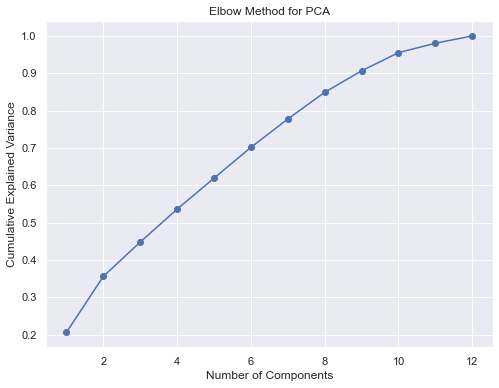

In [183]:
# Calculate the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance and see how many components are optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

##### About 10 principal components explain about 95% of the varience. We may not be able to reduce dimensionality

In [184]:
pca.explained_variance_ 

array([2.47460662, 1.79906711, 1.10372456, 1.05717243, 0.99610221,
       0.98996246, 0.91043244, 0.85851335, 0.69084536, 0.58486082,
       0.30148985, 0.23607991])

In [185]:
# Proportion of Variance (from PC1 to PC12)
pca.explained_variance_ratio_

array([0.20616813, 0.14988657, 0.09195515, 0.08807673, 0.08298876,
       0.08247723, 0.07585131, 0.07152575, 0.05755674, 0.0487268 ,
       0.02511817, 0.01966864])

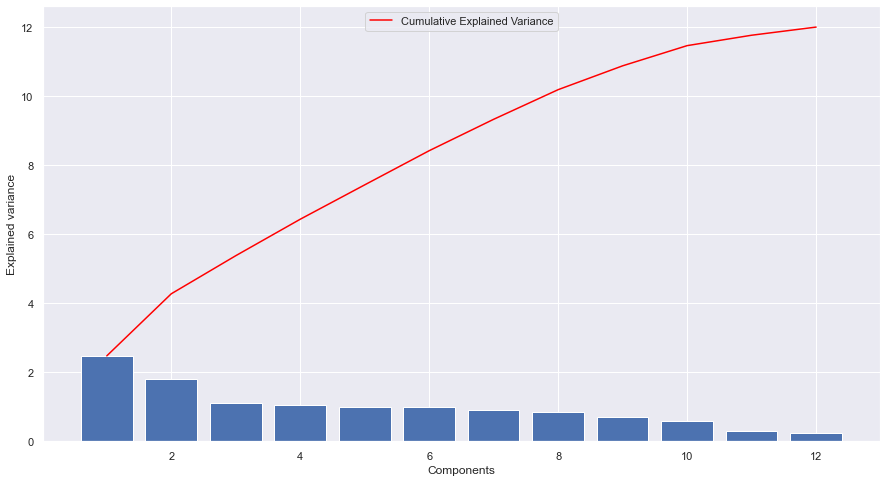

In [186]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper center')

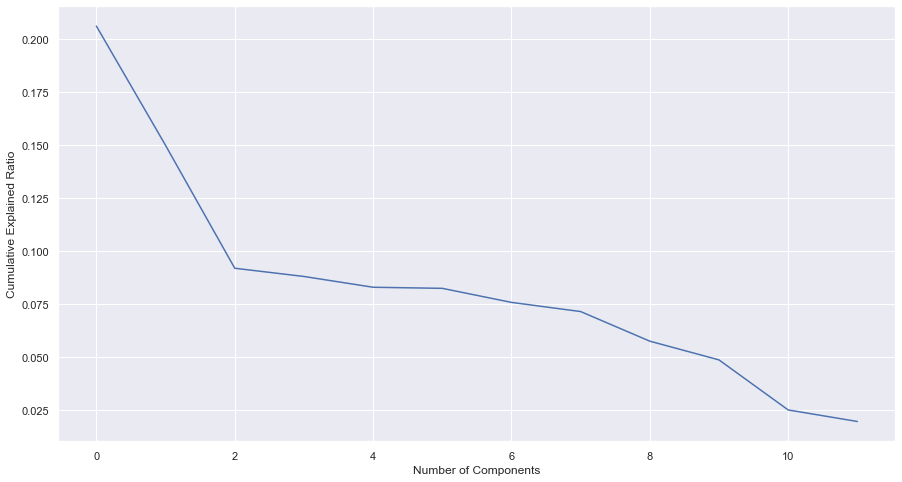

In [187]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Ratio')
plt.show()


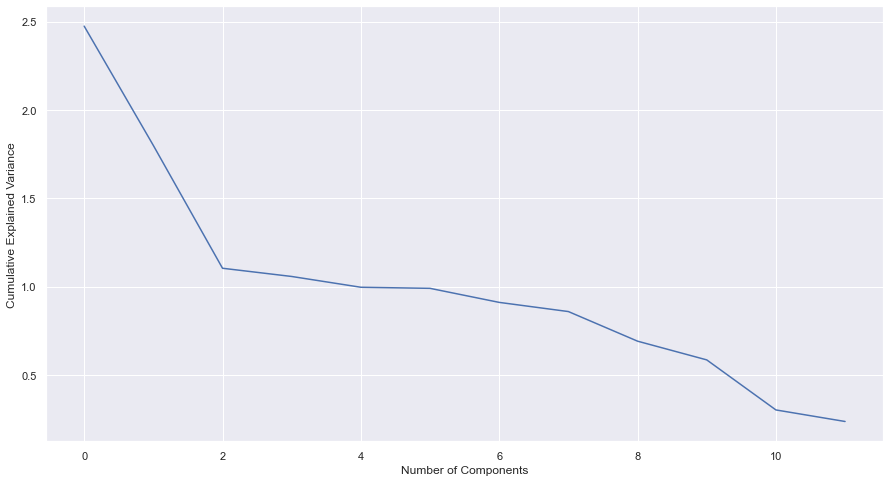

In [188]:
plt.plot(pca.explained_variance_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### 7. Linear Regressions to Check Linearity between Features and Price
We need to see whether the relationships between the features in our dataset and price are linear or non-linear so we can determine which model to use. If there is no linear relationship, we can use Suport Vector Regressor with a non-linear kernel, and an XGBoost Regressor, and compare the MAPE.

In [189]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded'],
      dtype='object')

In [190]:
data.isnull().sum()

ID                            0
District                      0
Neighborhood                  0
PropertyType                  0
CancellationPolicy            0
Accommodates                  0
RoomType                      0
Bathrooms                     0
Bedrooms                      0
CleaningFee                   0
Latitude                      0
Longitude                     0
ReviewRating                  0
Price                         0
District_encoded              0
Neighborhood_encoded          0
PropertyType_encoded          0
CancellationPolicy_encoded    0
RoomType_encoded              0
dtype: int64

#### 7.1 All features vs Price Linearity

In [191]:
columns_to_exclude = ['Price', 'ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy','RoomType']
X = data.loc[:, ~data.columns.isin(columns_to_exclude)]
y = data['Price']

In [192]:
# We need to do a stratified split because we want all Districts to be in both the training and testing splits. 
# 80% of the rentals will be used to train and 20% to test.
# We are stating the random_state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['District'], random_state=42)

In [193]:
X_train.District_encoded.head()

1696    2
819     2
2988    2
2360    2
2656    2
Name: District_encoded, dtype: int64

In [194]:
# We are initializing the linear regression model
model = LinearRegression()

In [195]:
model.fit(X_train, y_train)

LinearRegression()

In [196]:
# we use the test dataset to predict prices
y_pred = model.predict(X_test)

In [197]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 4493.507196387772


In [198]:
### We are defining the residuals and we plot them. If they're scattered around 0, it's a linear relationship
residuals = y_test - y_pred

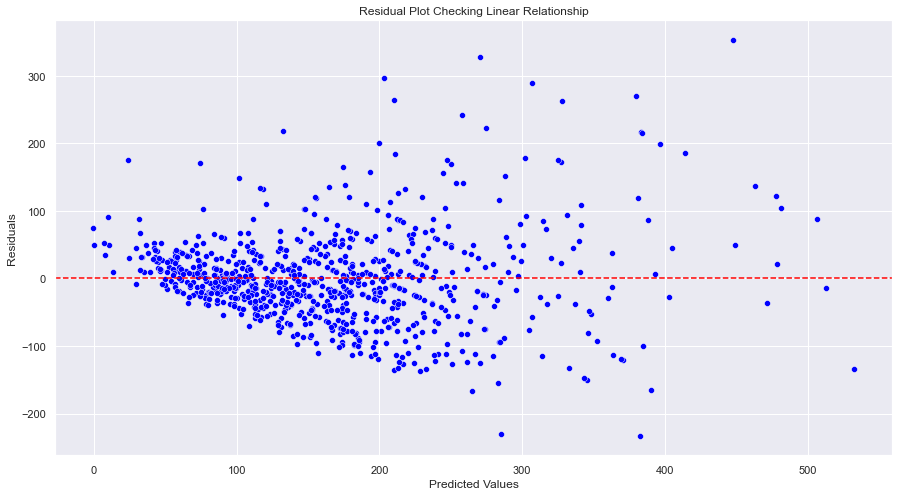

In [199]:
sns.scatterplot(x=y_pred, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot Checking Linear Relationship")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

##### The residuals do not indicate linear relationship. Let's check for linearity each individual feature against Price 

In [200]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded'],
      dtype='object')

In [201]:
# we are going to build linear regressions for each of these features vs price
predictor_columns = ['District_encoded', 'Neighborhood_encoded', 'PropertyType_encoded', 'CancellationPolicy_encoded',
       'Accommodates', 'RoomType_encoded', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price']

In [202]:
# Since we are building many linear regression models, we need to store them in a dictionary 
linear_models = {}

# We are iterating through each column and fit linear regression models
for col in predictor_columns:
    X = data[[col]] 
    y = data['Price']  # We are predicting this variable

    # We initialize the linear regressor
    model = LinearRegression()
    # We fit it to our data
    model.fit(X, y)
    
    # We store each model in the dictionary we created earlier
    linear_models[col] = model
    

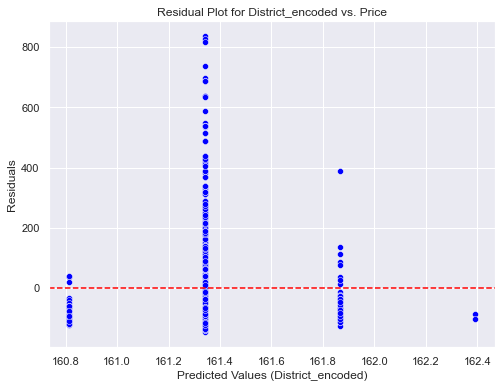

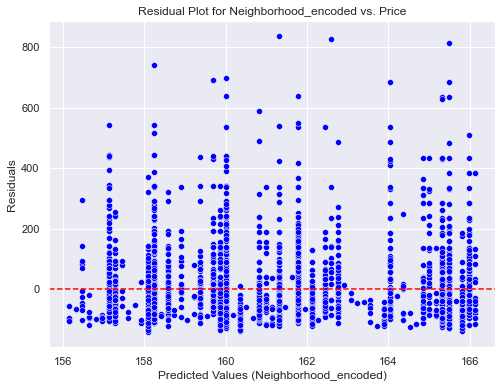

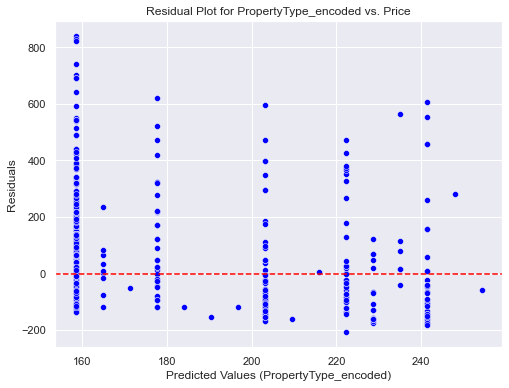

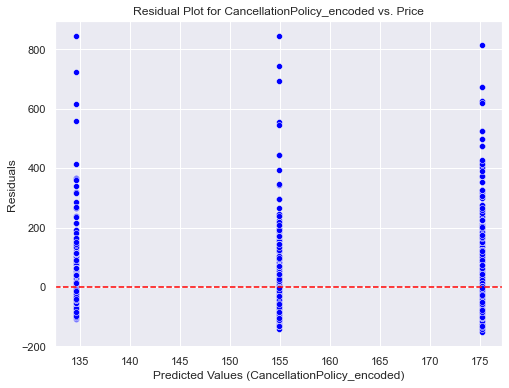

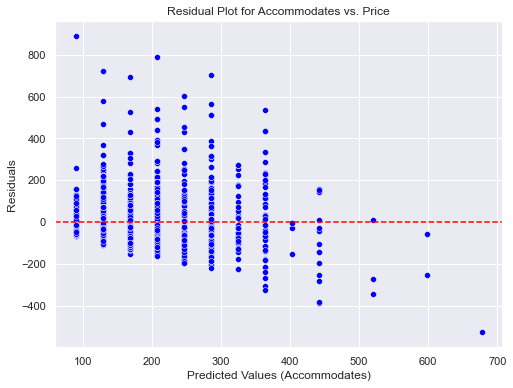

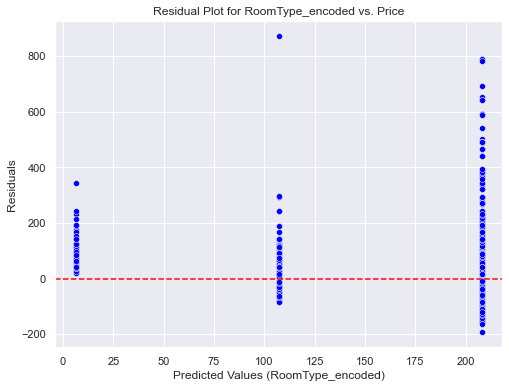

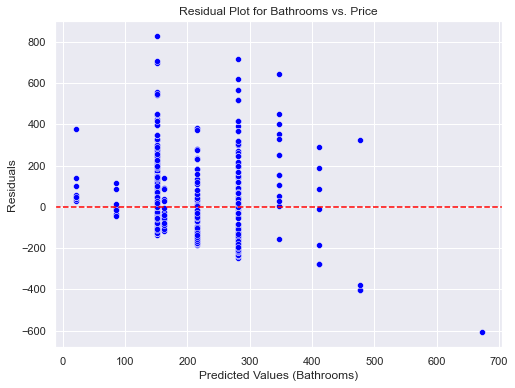

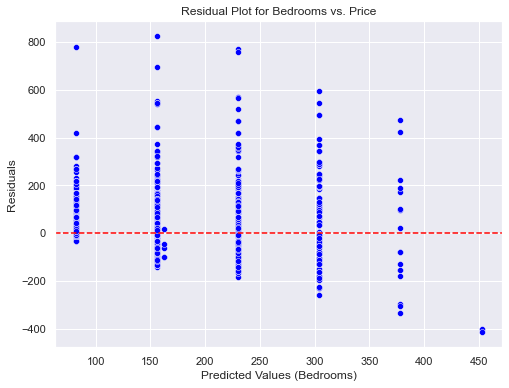

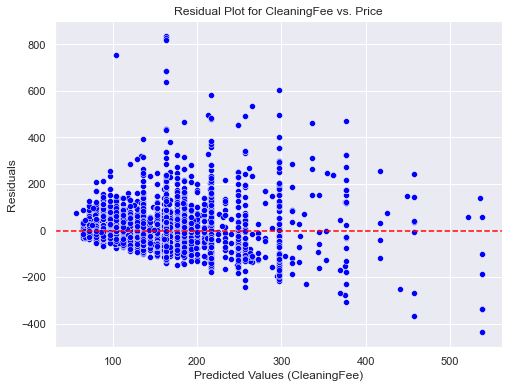

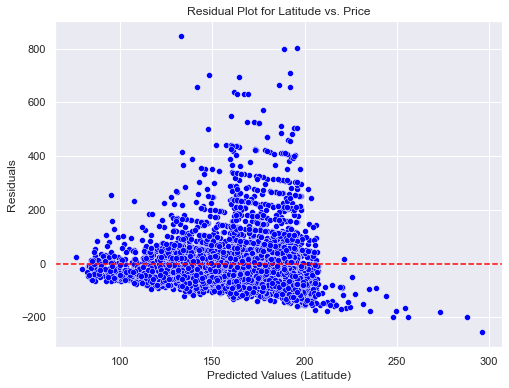

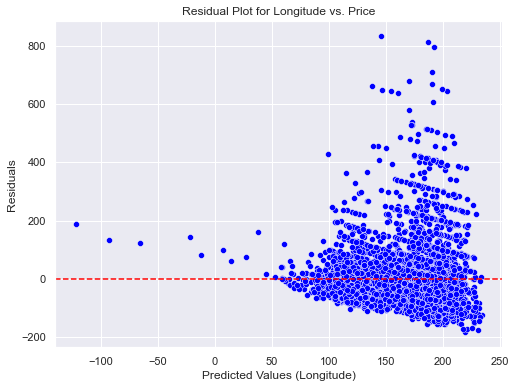

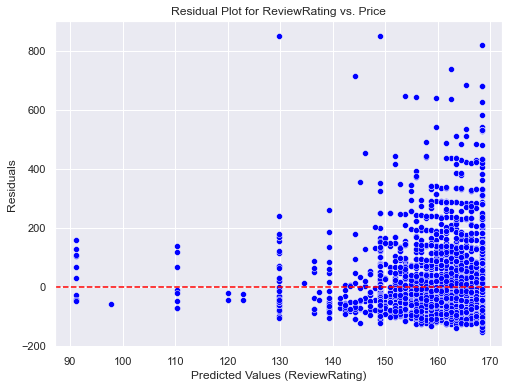

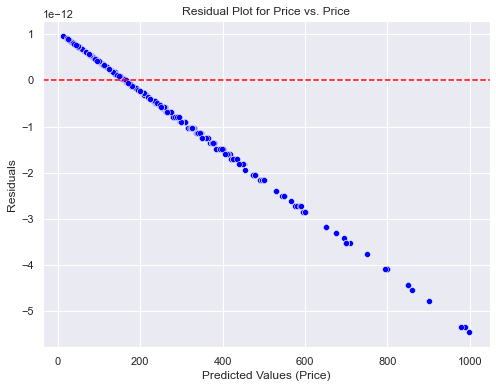

In [203]:
# We need to store the residuals for each model we created in a dictionary 
residuals = {}
# We need to plot the residuals for each model, so we need another dictionary
residual_plots = {}

# Iterate through the linear models and calculate residuals and create plots
for col, model in linear_models.items():
    # We are predicting on each column's model
    y_pred = model.predict(data[[col]])
    
    # Then we are calculating each model's residuals
    residual = data['Price'] - y_pred
    residuals[col] = residual
    
    # Finally we are creating each model's residual plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residual, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residual Plot for {col} vs. Price")
    plt.xlabel(f"Predicted Values ({col})")
    plt.ylabel("Residuals")
    plt.grid(True)
    residual_plots[col] = plt  # We store the plot in the dictionary we created earlier

# We are displaying the residual plots for each column
for col, plot in residual_plots.items():
    plot.show()

##### No feature has a linear relationship with Price

### 8. Feature Engineering

In [204]:
## create a new column called overall_size, to get a sense of how many bathrooms + bedrooms a rental has
data['Overall_Size'] = data['Bathrooms'] + data['Bedrooms']

In [205]:
## create a new column called person_per_bedroom, to get a sense of how much a person pays per a bedroom.
## There could be 0 Bedrooms, so we need to make sure that the division doesn't return infinity.
## That's why we need a check - if there are 0 bedrooms but 2 people, there will be 2 people per rental (bedroom)
data['Person_per_Bedroom'] = data.apply(lambda row: row['Accommodates'] if row['Bedrooms'] == 0 else row['Accommodates'] / row['Bedrooms'], axis=1)

In [206]:
## person per bathroom - similar to person per bedroom
data['Person_per_Bathroom'] = data.apply(lambda row: row['Accommodates'] if row['Bathrooms'] == 0 else row['Accommodates'] / row['Bathrooms'], axis=1)

In [207]:
## average reviewrating per neighborhood
data['Avg_ReviewRating_in_Neighborhood'] = data.groupby('Neighborhood')['ReviewRating'].transform('mean')

In [208]:
## average cleaningfee per neighborhood
data['Avg_CleaningFee_in_Neighborhood'] = data.groupby('Neighborhood')['CleaningFee'].transform('mean')

In [209]:
## bathroom to bedroom ratio
data['Bathroom_to_Bedroom_Ratio'] = data.apply(lambda row: 0 if row['Bedrooms'] == 0 or row['Bathrooms'] == 0 else row['Bathrooms'] / row['Bedrooms'], axis=1)

#### We need to make categorical variables - ranges - from numerical variables
### 8.1. Histograms to determine the ranges for each column

In [210]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded', 'Overall_Size',
       'Person_per_Bedroom', 'Person_per_Bathroom',
       'Avg_ReviewRating_in_Neighborhood', 'Avg_CleaningFee_in_Neighborhood',
       'Bathroom_to_Bedroom_Ratio'],
      dtype='object')

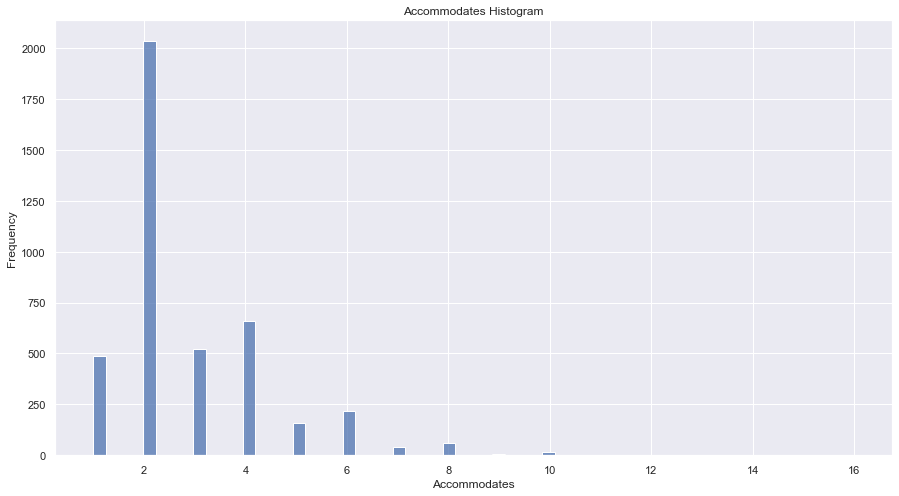

In [211]:
sns.histplot(data.Accommodates) # We are going to leave out the 'bins' parameter so seaborn can find the number of bins needed
 
plt.xlabel('Accommodates')
plt.ylabel('Frequency')
plt.title('Accommodates Histogram')

# Show the histogram
plt.show()

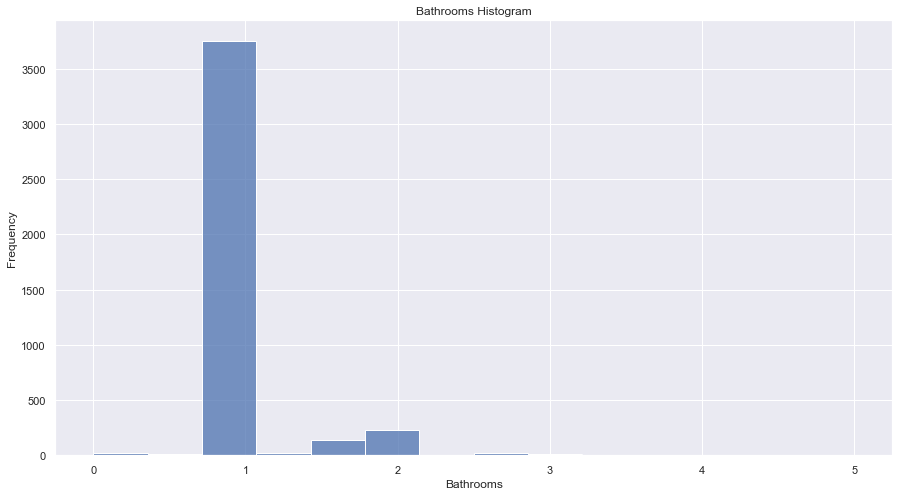

In [212]:
sns.histplot(data.Bathrooms) 

plt.xlabel('Bathrooms')
plt.ylabel('Frequency')
plt.title('Bathrooms Histogram')

# Show the histogram
plt.show()

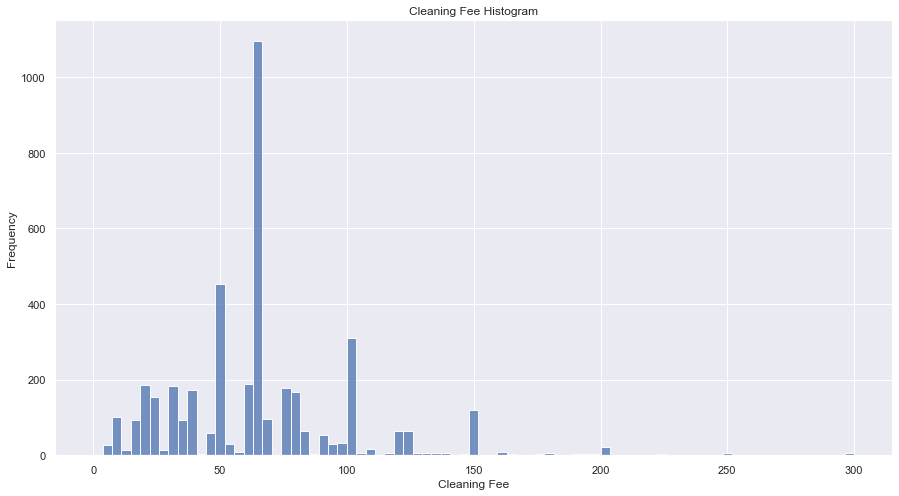

In [213]:
sns.histplot(data.CleaningFee) 

plt.xlabel('Cleaning Fee')
plt.ylabel('Frequency')
plt.title('Cleaning Fee Histogram')

# Show the histogram
plt.show()

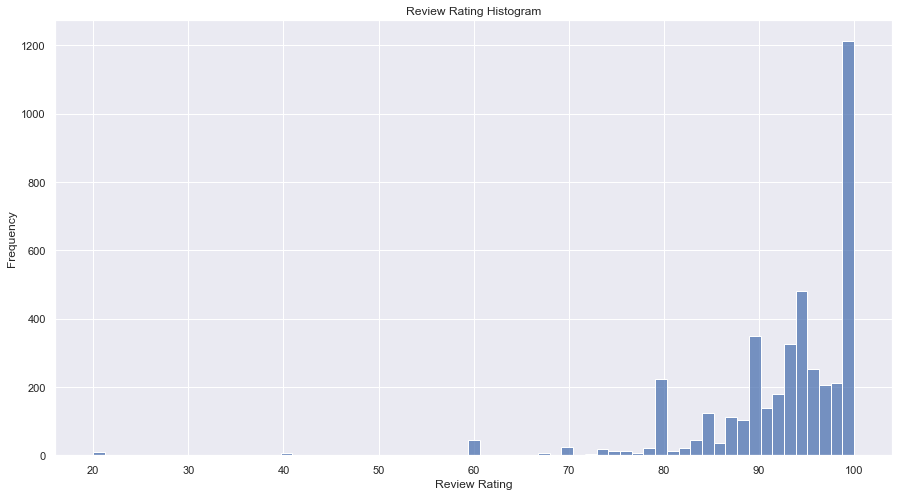

In [214]:
sns.histplot(data.ReviewRating) 

# Add labels and title
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.title('Review Rating Histogram')

# Show the histogram
plt.show()

#### For consistency, we denote all the ranges in all columns with: small, medium, large, very large.

In [215]:
# Categorize 'Accommodates' values: 0-2 are small rentals, 3-4 are medium rentals, 5-8 are large rentals, and 9 and above are very large rentals
data['Accommodates_Category'] = pd.cut(
    data['Accommodates'],
    bins=[0, 3, 5, 9, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [216]:
## check whether it worked
data[['Accommodates', 'Accommodates_Category']].sort_values('Accommodates')

,Accommodates,Accommodates_Category
4200,1,Small
1301,1,Small
3367,1,Small
2276,1,Small
2277,1,Small
556,1,Small
557,1,Small
3363,1,Small
1302,1,Small
3362,1,Small


In [217]:
# Categorize 'Bathrooms' values: 0-1 are small rentals, 2-3 are medium rentals, 4 are large rentals, and 5 and above are very large rentals
data['Bathrooms_Category'] = pd.cut(
    data['Bathrooms'],
    bins=[0, 2, 3, 5, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [218]:
# Categorize 'CleaningFee' values: 0-50 are small rentals, 51-100 are medium rentals, 101-150 are large rentals, and 151 and above are very large rentals
data['CleaningFee_Category'] = pd.cut(
    data['CleaningFee'],
    bins=[0, 51, 101, 151, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [219]:
# Categorize 'ReviewRating' values: 0-50 are small rentals, 51-70 are medium rentals, 71-85 are large rentals, and 86 and above are very large rentals
data['ReviewRating_Category'] = pd.cut(
    data['ReviewRating'],
    bins=[0, 51, 71, 86, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

#### Label Encode the new categorical columns

In [220]:
categorical_columns = ['Accommodates_Category',
       'Bathrooms_Category', 'CleaningFee_Category', 'ReviewRating_Category']

# Since we are doing label encoding on all columns at once, in a loop, 
# we need a dictionary to store LabelEncoder instances for each column

label_encoders = {}

# We would like to see how the original value maps to the new label encoded value,
# so we need to create a dictionary to map the original values to the encoded values 

encoded_value_mappings = {}

# Perform label encoding for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])  # Replace the original values with encoded values
    label_encoders[col] = le
    
    # Create a mapping dictionary for the current column
    encoded_value_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [221]:
### show the mappings
encoded_value_mappings

{'Accommodates_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3},
 'Bathrooms_Category': {'Large': 0, 'Medium': 1, 'Small': 2, 'Very Large': 3},
 'CleaningFee_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3},
 'ReviewRating_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3}}

In [222]:
data.head()

,ID,District,Neighborhood,PropertyType,CancellationPolicy,Accommodates,RoomType,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating,Price,District_encoded,Neighborhood_encoded,PropertyType_encoded,CancellationPolicy_encoded,RoomType_encoded,Overall_Size,Person_per_Bedroom,Person_per_Bathroom,Avg_ReviewRating_in_Neighborhood,Avg_CleaningFee_in_Neighborhood,Bathroom_to_Bedroom_Ratio,Accommodates_Category,Bathrooms_Category,CleaningFee_Category,ReviewRating_Category,Accommodates_Category_encoded,Bathrooms_Category_encoded,CleaningFee_Category_encoded,ReviewRating_Category_encoded
0,5300082,Manhattan,East Village,Apartment,strict,2,Entire home/apt,1.000000,0.000000,75.000000,40.729555,-73.981665,86.000000,160.000000,2,13,0,2,0,1.000000,2.000000,2.000000,93.206813,67.342661,0.000000,Small,Small,Medium,Very Large,2,2,1,3
1,17634206,Manhattan,Hell's Kitchen,Apartment,flexible,2,Entire home/apt,1.000000,1.000000,66.646525,40.766988,-73.984802,100.000000,130.000000,2,24,0,0,0,2.000000,2.000000,2.000000,93.000000,69.242271,1.000000,Small,Small,Medium,Very Large,2,2,1,3
2,4025329,Manhattan,Harlem,Apartment,strict,4,Entire home/apt,1.000000,0.000000,69.000000,40.815859,-73.941165,91.000000,129.000000,2,23,0,2,0,1.000000,4.000000,4.000000,92.499089,55.659232,0.000000,Medium,Small,Medium,Very Large,1,2,1,3
3,10096773,Manhattan,Chelsea,Apartment,flexible,2,Entire home/apt,1.000000,1.000000,60.000000,40.745773,-74.000744,100.000000,145.000000,2,6,0,0,0,2.000000,2.000000,2.000000,94.437209,75.181311,1.000000,Small,Small,Medium,Very Large,2,2,1,3
4,11616592,Manhattan,West Village,Apartment,strict,9,Entire home/apt,2.500000,3.000000,160.000000,40.737583,-74.005531,94.000000,399.000000,2,61,0,2,0,5.500000,3.000000,3.600000,94.456647,80.596319,0.833333,Very Large,Medium,Very Large,Very Large,3,1,3,3


## Visualization, Modeling, Machine Learning

Can you build a model that can evaluate the lodging and propose a fair price for a night dependent on the given features? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.

- **Build an optimized model that effectively solves the business problem.**
- **Read the test.csv file and prepare features for testing.**

## Rental Predictor Model's Success

The model we built using data that describes the rental in terms of type, capacity, location, cleaning fee, and rating is able to predict prices for new rentals. 

The most important features the model found duing training were the number of bedrooms a rental had, the bathroom to bedroom ratio, that is, how many bathrooms the rental has per a single bedroom, the price per bedroom, and the room type. This is in line with the ground truth analysis we did on historical data. 

### Model Selection

We have determined that we need to use models that can grasp the non-linearity in the data. First we are going to build an SVR model and then an XGBoost model, and compare the two.

### 1. Support Vector Regressor with a non-linear kernel

In [223]:
from sklearn.svm import SVR

In [224]:
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded', 'Overall_Size',
       'Person_per_Bedroom', 'Person_per_Bathroom',
       'Avg_ReviewRating_in_Neighborhood', 'Avg_CleaningFee_in_Neighborhood',
       'Bathroom_to_Bedroom_Ratio', 'Accommodates_Category',
       'Bathrooms_Category', 'CleaningFee_Category', 'ReviewRating_Category',
       'Accommodates_Category_encoded', 'Bathrooms_Category_encoded',
       'CleaningFee_Category_encoded', 'ReviewRating_Category_encoded'],
      dtype='object')

In [225]:
columns_to_exclude = ['Price', 'ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'RoomType', 'Accommodates_Category',
       'Bathrooms_Category', 'CleaningFee_Category','ReviewRating_Category']
X = data.loc[:, ~data.columns.isin(columns_to_exclude)]
y = data['Price']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['District_encoded'], random_state=42)

In [227]:
# we need to create a function to calculate the mean absolute percentage error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
# We initialize the model
model = SVR(kernel='rbf') # the rbf stands for Radial Basis Function Kernel, which is used in non-linear relationships because it can map data into a high-dimensional space

In [229]:
# We fit it to our training data
model.fit(X_train, y_train)

SVR()

In [230]:
# we use our test data to predict
y_pred = model.predict(X_test)

In [231]:
# we find the evaluation metric and print it
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

43.40367389896279


##### About 43% mean absolute percentage error isn't very good. Let's try XGBoost

### 2. XGBoost Regressor

In [232]:
# initialize the model
xgb_model = XGBRegressor()

In [233]:
# we need to define the hyperparemeters' ranges because we are doing hyperparameter tuning.
# this allows us to create many models so we can try out different values for the parameters
# and find the model with the parameters that have the best evaluation metric

hyperparameters = {
    'n_estimators': [10, 30, 50],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
}

In [234]:
# Perform randomized search cross-validation
search = RandomizedSearchCV(xgb_model, hyperparameters, scoring='neg_mean_squared_error', cv=5, n_iter=10) # cv stands for cross-validation folds, and n_iter is ther number of parameter combinations to try
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2],
                                        'max_depth': [5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 30, 50]},
                   scoring='neg_mean_squared_error')

In [235]:
# Get the best model and its hyperparameters
best_model = search.best_estimator_
best_hyperparameters = search.best_params_

In [236]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Best Model MAPE: {mape}")

Best Model MAPE: 30.923584583912618


##### XGBoost performs better on the training set

In [237]:
# Retrieve the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
n_estimators: 10
min_child_weight: 5
max_depth: 7
learning_rate: 0.2


#### Let's plot the Observed (True) Values and the Predicted values, to see where the model makes mistakes

Text(0.5, 1.0, 'Observed vs Predicted')

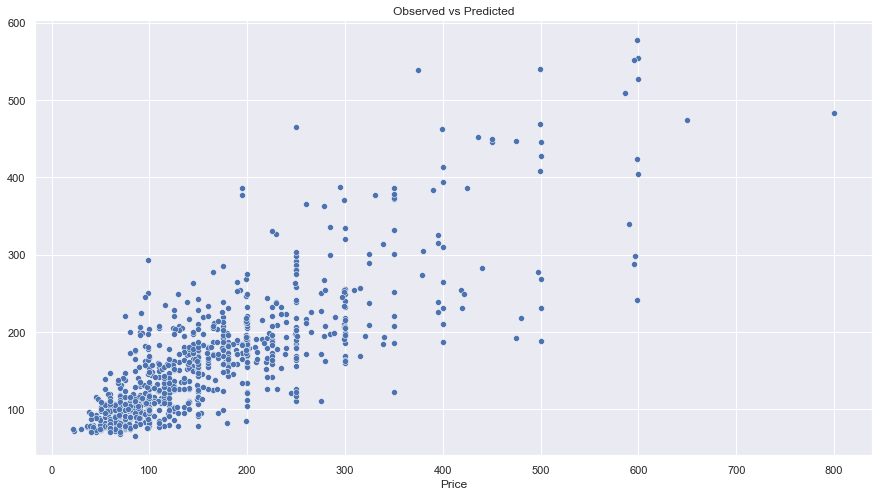

In [238]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred).set_title('Observed vs Predicted')

##### The model slightly misclassifies more expensive rentals

#### Let's see which features are important

In [239]:
importance = best_model.feature_importances_
feature_names = X_train.columns

In [240]:
indices = np.argsort(importance)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importance = importance[indices]

In [241]:
top_10_feature_names = sorted_feature_names[:10]
top_10_importance = sorted_importance[:10]

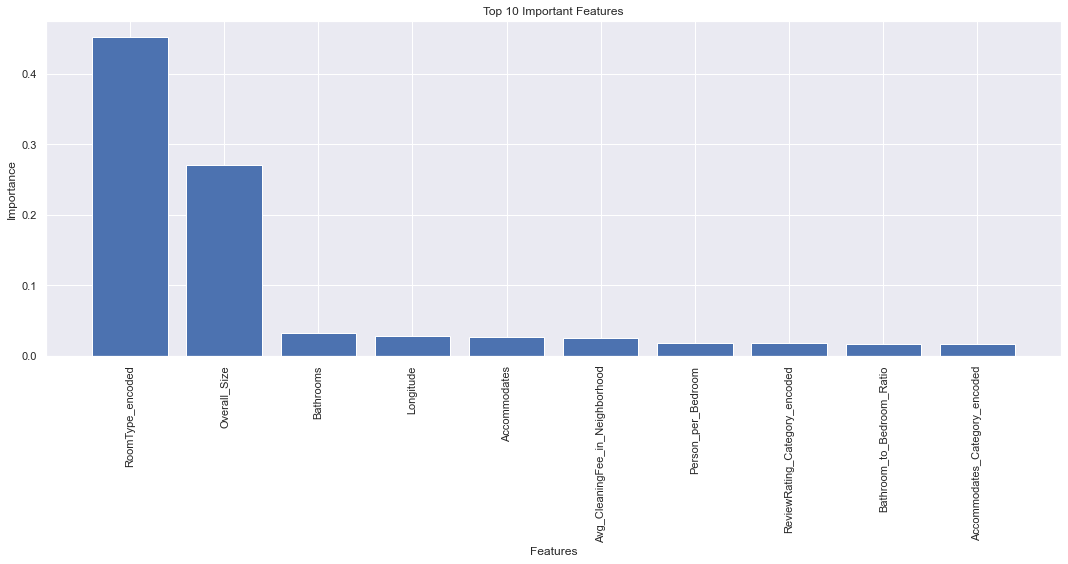

In [242]:
plt.bar(range(len(top_10_importance)), top_10_importance, tick_label=top_10_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

## Test the model on a test dataset that the model doesn't see during training

In [243]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,ID,District,Neighborhood,PropertyType,CancellationPolicy,Accommodates,RoomType,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating
0,8760775,Manhattan,Murray Hill,Apartment,flexible,1,Private room,1.000000,1.000000,63.827637,40.749400,-73.978226,95.000000
1,16425551,Manhattan,Chinatown,Apartment,flexible,1,Private room,1.000000,1.000000,35.000000,40.716220,-73.991230,95.000000
2,15043585,Manhattan,Hell's Kitchen,Apartment,flexible,2,Private room,1.000000,1.000000,63.827637,40.761096,-73.987602,90.000000
3,16516930,Manhattan,Gramercy,Apartment,strict,6,Entire home/apt,1.000000,3.000000,150.000000,40.736475,-73.985136,60.000000
4,1891017,Manhattan,Chelsea,Apartment,strict,2,Entire home/apt,1.000000,0.000000,69.000000,40.750661,-74.003774,96.000000


In [244]:
test_data_ID = test_data.ID

### Let's do the same Data Preprocessing for the Test Data as we did for the Training Data

#### Label Encode Step 1

In [245]:
test_data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating'],
      dtype='object')

In [246]:
categorical_columns = ['District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 'RoomType']

In [247]:
# Since we are doing label encoding on all columns at once, in a loop, 
# we need a dictionary to store LabelEncoder instances for each column

label_encoders = {}

# We would like to see how the original value maps to the new label encoded value,
# so we need to create a dictionary to map the original values to the encoded values 

encoded_value_mappings = {}

# Perform label encoding for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    test_data[col + '_encoded'] = le.fit_transform(test_data[col])  # Replace the original values with encoded values
    label_encoders[col] = le
    
    # Create a mapping dictionary for the current column
    encoded_value_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

In [248]:
### show the mappings
encoded_value_mappings

{'District': {'Brooklyn': 0, 'Manhattan': 1, 'Queens': 2},
 'Neighborhood': {'Astoria': 0,
  'Battery Park City': 1,
  'Bedford-Stuyvesant': 2,
  'Brooklyn Heights': 3,
  'Bushwick': 4,
  'Chelsea': 5,
  'Chinatown': 6,
  'Civic Center': 7,
  'Clinton Hill': 8,
  'East Harlem': 9,
  'East Village': 10,
  'Financial District': 11,
  'Flatiron District': 12,
  'Gramercy': 13,
  'Greenpoint': 14,
  'Greenwich Village': 15,
  'Harlem': 16,
  "Hell's Kitchen": 17,
  'Inwood': 18,
  'Kips Bay': 19,
  'Little Italy': 20,
  'Long Island City': 21,
  'Lower East Side': 22,
  'Midtown': 23,
  'Morningside Heights': 24,
  'Murray Hill': 25,
  'NoHo': 26,
  'Nolita': 27,
  'Roosevelt Island': 28,
  'SoHo': 29,
  'Stuyvesant Town': 30,
  'Theater District': 31,
  'Tribeca': 32,
  'Two Bridges': 33,
  'Upper East Side': 34,
  'Upper West Side': 35,
  'Washington Heights': 36,
  'West Village': 37,
  'Williamsburg': 38},
 'PropertyType': {'Apartment': 0,
  'Bed & Breakfast': 1,
  'Bungalow': 2,
  'Co

In [249]:
## create a new column called overall_size, to get a sense of how many bathrooms + bedrooms a rental has
test_data['Overall_Size'] = test_data['Bathrooms'] + test_data['Bedrooms']

In [250]:
## create a new column called person_per_bedrrom, to get a sense of how much a person pays per a bedroom.
## There could be 0 Bedrooms, so we need to make sure that the division doesn't return infinity.
## That's why we need a check - if there are 0 bedrooms but 2 people, there will be 2 people per rental (bedroom)
test_data['Person_per_Bedroom'] = test_data.apply(lambda row: row['Accommodates'] if row['Bedrooms'] == 0 else row['Accommodates'] / row['Bedrooms'], axis=1)

In [251]:
## person per bathroom - similar to person per bedroom
test_data['Person_per_Bathroom'] = test_data.apply(lambda row: row['Accommodates'] if row['Bathrooms'] == 0 else row['Accommodates'] / row['Bathrooms'], axis=1)

In [252]:
## average reviewrating per neighborhood
test_data['Avg_ReviewRating_in_Neighborhood'] = test_data.groupby('Neighborhood')['ReviewRating'].transform('mean')

In [253]:
## average cleaningfee per neighborhood
test_data['Avg_CleaningFee_in_Neighborhood'] = test_data.groupby('Neighborhood')['CleaningFee'].transform('mean')

In [254]:
## bathroom to bedroom ratio
test_data['Bathroom_to_Bedroom_Ratio'] = test_data.apply(lambda row: 0 if row['Bedrooms'] == 0 or row['Bathrooms'] == 0 else row['Bathrooms'] / row['Bedrooms'], axis=1)

#### Create the Ranges for the Numerical Variables

In [255]:
# Categorize 'Accommodates' values: 0-2 are small rentals, 3-4 are medium rentals, 5-8 are large rentals, and 9 and above are very large rentals
test_data['Accommodates_Category'] = pd.cut(
    test_data['Accommodates'],
    bins=[0, 3, 5, 9, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [256]:
# Categorize 'Bathrooms' values: 0-1 are small rentals, 2-3 are medium rentals, 4 are large rentals, and 5 and above are very large rentals
test_data['Bathrooms_Category'] = pd.cut(
    test_data['Bathrooms'],
    bins=[0, 2, 3, 5, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [257]:
# Categorize 'CleaningFee' values: 0-50 are small rentals, 51-100 are medium rentals, 101-150 are large rentals, and 151 and above are very large rentals
test_data['CleaningFee_Category'] = pd.cut(
    test_data['CleaningFee'],
    bins=[0, 51, 101, 151, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

In [258]:
# Categorize 'ReviewRating' values: 0-50 are small rentals, 51-70 are medium rentals, 71-85 are large rentals, and 86 and above are very large rentals
test_data['ReviewRating_Category'] = pd.cut(
    test_data['ReviewRating'],
    bins=[0, 51, 71, 86, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    right=False  
)

#### Label Encoding Step 2

In [259]:
categorical_columns = ['Accommodates_Category',
       'Bathrooms_Category', 'CleaningFee_Category', 'ReviewRating_Category']

# Since we are doing label encoding on all columns at once, in a loop, 
# we need a dictionary to store LabelEncoder instances for each column

label_encoders = {}

# We would like to see how the original value maps to the new label encoded value,
# so we need to create a dictionary to map the original values to the encoded values 

encoded_value_mappings = {}

# Perform label encoding for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    test_data[col + '_encoded'] = le.fit_transform(test_data[col])  # Replace the original values with encoded values
    label_encoders[col] = le
    
    # Create a mapping dictionary for the current column
    encoded_value_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [260]:
encoded_value_mappings

{'Accommodates_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3},
 'Bathrooms_Category': {'Large': 0, 'Medium': 1, 'Small': 2},
 'CleaningFee_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3},
 'ReviewRating_Category': {'Large': 0,
  'Medium': 1,
  'Small': 2,
  'Very Large': 3}}

In [261]:
test_data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'District_encoded',
       'Neighborhood_encoded', 'PropertyType_encoded',
       'CancellationPolicy_encoded', 'RoomType_encoded', 'Overall_Size',
       'Person_per_Bedroom', 'Person_per_Bathroom',
       'Avg_ReviewRating_in_Neighborhood', 'Avg_CleaningFee_in_Neighborhood',
       'Bathroom_to_Bedroom_Ratio', 'Accommodates_Category',
       'Bathrooms_Category', 'CleaningFee_Category', 'ReviewRating_Category',
       'Accommodates_Category_encoded', 'Bathrooms_Category_encoded',
       'CleaningFee_Category_encoded', 'ReviewRating_Category_encoded'],
      dtype='object')

In [262]:
test_data = test_data.drop(columns = ['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 
                                      'RoomType', 'Accommodates_Category', 'Bathrooms_Category', 
                                      'CleaningFee_Category', 'ReviewRating_Category'])

In [272]:
test_data.isnull().sum()

Accommodates                        0
Bathrooms                           0
Bedrooms                            0
CleaningFee                         0
Latitude                            0
Longitude                           0
ReviewRating                        0
District_encoded                    0
Neighborhood_encoded                0
PropertyType_encoded                0
CancellationPolicy_encoded          0
RoomType_encoded                    0
Overall_Size                        0
Person_per_Bedroom                  0
Person_per_Bathroom                 0
Avg_ReviewRating_in_Neighborhood    0
Avg_CleaningFee_in_Neighborhood     0
Bathroom_to_Bedroom_Ratio           0
Accommodates_Category_encoded       0
Bathrooms_Category_encoded          0
CleaningFee_Category_encoded        0
ReviewRating_Category_encoded       0
dtype: int64

In [273]:
test_predictions = best_model.predict(test_data)

In [274]:
test_predictions

array([104.79808 ,  83.86667 , 110.263016, ..., 245.91713 ,  77.12315 ,
        73.95072 ], dtype=float32)

In [278]:
data.Price.describe()

count   4201.000000
mean     161.343014
std      110.364870
min       14.000000
25%       90.000000
50%      130.000000
75%      200.000000
max      999.000000
Name: Price, dtype: float64

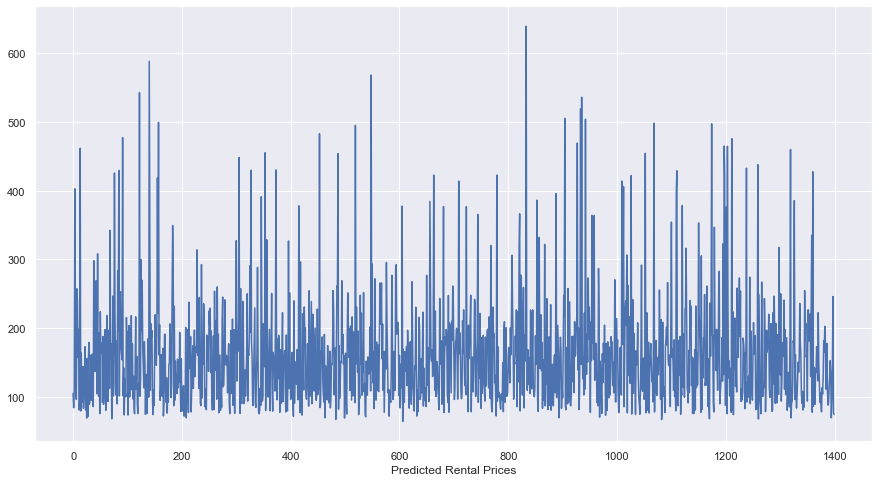

In [281]:
plt.plot(test_predictions)
plt.xlabel('Predicted Rental Prices')
plt.show()

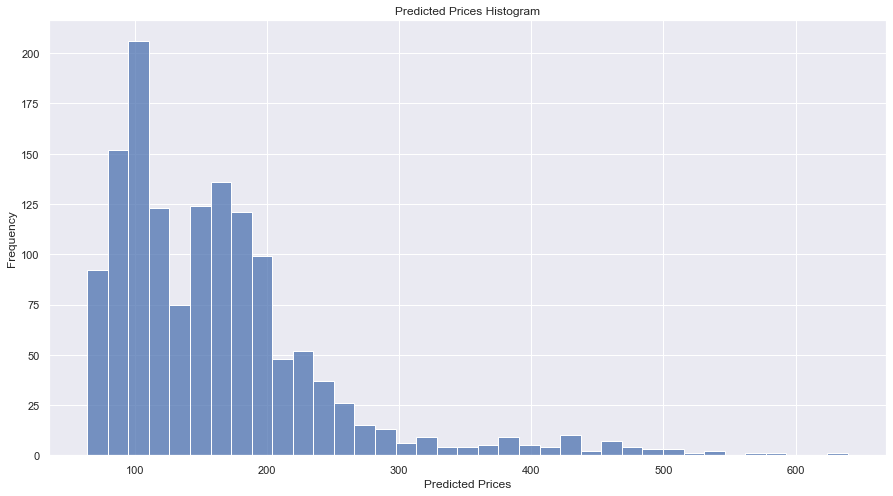

In [282]:
sns.histplot(test_predictions) 

plt.xlabel('Predicted Prices')
plt.ylabel('Frequency')
plt.title('Predicted Prices Histogram')

# Show the histogram
plt.show()

---